# Comparison of GPyTorch and GAUCHE Libraries
_Drew Gjerstad, University of Minnesota_

**Includes content from the GPyTorch's and GAUCHE's documentation.**

## Introduction

[GPyTorch](https://gpytorch.ai) is a Python library that contains a highly
efficient and modular implementation of Gaussian processes (GPs) with GPU
acceleration in PyTorch, a popular deep learning framework. Gaussian processes
can be used to form surrogate models within the Bayesian optimization paradigm.
However, sometimes we wish to build these surrogate models based on data with
irregular representations such as graph-based data. This is where the
[GAUCHE](https://github.com/leojklarner/gauche) library becomes attractive. The
GAUCHE package was originally designed for building Gaussian processes and
performing Bayesian optimization on molecular representations. However, it can
be used to build Gaussian processes for graph-based data in general.

### Installing GPyTorch
To install `gpytorch`, run the following cell. Alternatively, run this command
in your terminal: `pip install gpytorch`. Note that this requires Python version
3.8 or higher.

In [ ]:
%pip install gpytorch

### Installing GAUCHE
To install `gauche`, run the following cell. Alternatively, run this command in
your terminal: `pip install gauche`. Note that this requires Python version 3.9
or higher and additional installation options are available at the
[gauche GitHub repository](https://github.com/leojklarner/gauche).

In [ ]:
%pip install gauche

## GPyTorch Implementation

Before we begin examining the implementation of the GPyTorch library, the
documentation for the entire library in addition to examples (some of which will
be featured in this notebook) can be found here:
[GPyTorch docs](https://docs.gpytorch.ai/en/stable/). First, we will examine the
different components that make up the "anatomy" of the library.

 * `gpytorch.models` contains various models that will handle the inference.
 * `gpytorch.likelihoods` contains multiple likelihood functions.
 * `gpytorch.means` contains several different prior means for the GP.
 * `gpytorch.kernels` contains different kernels used to determine the prior
    covariance of the GP.
 * `gpytorch.distributions` contains representations of different distributions.

These are the primary modules that are used to develop a Gaussian process. There
are a few other modules within the GPyTorch library but for the purposes of this
comparison these are the ones we will focus on.

### Basic Usage
In this section, we will develop a basic GPyTorch model and use it to make
predictions. This is based on the
[Simple GPyTorch Regression Tutorial](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html) that demonstrates how to train an RBF kernel Gaussian
process on a simple function. The function that is modeled is given by

$$y = \sin(2\pi x) + \epsilon$$

$$\epsilon \sim \mathcal{N}(0, 0.04)$$

In [1]:
# Load Dependencies
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [35]:
# Initialize Training Data
train_x = torch.linspace(0, 1, 100)  # 100 training points, evenly spaced
train_y = (torch.sin(train_x * (2 * math.pi)) + 
           torch.randn(train_x.size()) * math.sqrt(0.04))  # true function y

In the setup below, the way models are specified in GPyTorch enables flexibility
when it comes to defining a model. As shown below, if we want to compose two
kernels via addition this can either be done directly in the `__init__` method
or the outputs of each kernel can be added in the `forward` method.

`self.covar_module = ScaleKernel(RBFKernel() + LinearKernel())`

`covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)`

In [13]:
# Set Up Model (simplest form -> exact inference)
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        """
        This method takes the training data and likelihood to construct any
        objects which are needed for the model's `forward` method. Typically,
        this includes objects such as a mean module and a kernel module.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        """
        This method takes in some data, `x`, with shape (n, d) and returns a
        `MultivariateNormal` with the prior mean and covariance evaluated at
        `x`. Simply put, this method returns the vector mu(x) and the n-by-n
        matrix K_{xx} which represents the prior mean and covariance matrix of
        the Gaussian process, respectively.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [14]:
# Initialize Likelihood and Model
likelihood = GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Just like in PyTorch, the models in GPyTorch also have different modes for
training and evaluation: `.train()` and `.eval()`, respectively. The training
mode is used for optimizing model hyperparameters and the evaluation mode is
for computing predictions via the model posterior.

One notable difference when compared to other Gaussian process libraries, as is
standard practice in PyTorch, the training loop is defined by the user. In
addition, in GPyTorch, we utilize standard PyTorch optimizers from `torch.optim`
where all trainable parameters should have type `torch.nn.Parameter`. Finally,
since the GP models defined by GPyTorch extend `torch.nn.Module`, function calls
to `model.parameters()` and `model.named_parameters()` function as one would
expect in standard PyTorch.

The training loop defined below has the same components as a standard PyTorch
training loop:
1. Zero all parameter gradients.
2. Call the model, compute the loss.
3. Call backward on the loss to fill in gradients.
4. Take a step on the optimizer.

An advantage of GPyTorch over other GP libraries is that being able to directly
define the training loop allows for increased flexibility. For example, we are
able to save the parameters at each step of training (useful for keeping track
of the best model at different steps in the optimization process), or use
different learning rates for different parameters (useful for deep kernel
learning).

In [16]:
# Run Notebook in Testing Framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Set Model and Likelihood to Training Mode
model.train()
likelihood.train()

# Initialize Adam Optimizer (used to find optimal hyperparameters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the "Loss" for GPs (the marginal log-likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Define Training Loop
for i in range(training_iter):
    # (1) Zero gradients from previous iteration.
    optimizer.zero_grad()

    # (2) Call the model, compute the loss.
    output = model(train_x)
    loss = -mll(output, train_y)

    # (3) Call backward on the loss to fill in gradients.
    loss.backward()

    # Print Info (every 10 iterations to reduce output)
    if (i + 1) % 10 == 0:
        print('Iteration %d/%d - Loss: %.3f    lengthscale: %.3f    noise: %.3f'
               % (i + 1, training_iter, loss.item(),
                  model.covar_module.base_kernel.lengthscale.item(),
                  model.likelihood.noise.item()
                 )
        )

    # (4) Take a step on the optimizer.
    optimizer.step()

Iteration 10/50 - Loss: -0.064    lengthscale: 0.262    noise: 0.037
Iteration 20/50 - Loss: -0.064    lengthscale: 0.257    noise: 0.041
Iteration 30/50 - Loss: -0.064    lengthscale: 0.259    noise: 0.039
Iteration 40/50 - Loss: -0.064    lengthscale: 0.260    noise: 0.038
Iteration 50/50 - Loss: -0.064    lengthscale: 0.258    noise: 0.039


Once the model is trained, we can use it to make predictions. If we denote a
test point (`test_x`) as `x*` with the true output being `y*`, then
`model(test_x)` will return the model posterior distribution `p(f* | x*, X, y)`,
for training data `X`, `y`. This distribution is the posterior over the function
that we are trying to model, quantifying our model uncertainty.

On the other hand, `likelihood(model(test_x))` provides the posterior
predictive distribution `p(y* | x*, X, y)` which is the probability distribution
over the predicted output value. Therefore, obtaining the predictive mean and
variance, and then sampling from the Gaussian process at the given test points
can be accomplished using the calls in the next code cell below.

In [34]:
# Initialize Testing Data
test_x = torch.linspace(0, 1, 51)
test_y = (torch.sin(test_x * (2 * math.pi)) +
           torch.randn(test_x.size()) * math.sqrt(0.04))

In [ ]:
# Put Model Into Evaluation Model
model.eval()
likelihood.eval()

In [ ]:
# Obtain Predictive Mean and Variance, Sample from GP
f_pred = model(test_x)
y_pred = likelihood(model(test_x))

f_mean = f_pred.mean
f_var = f_pred.variance
f_covar = f_pred.covariance_matrix
f_samples = f_pred.sample(sample_shape=torch.Size((1000,)))

In [32]:
# Make Predictions With the Model
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

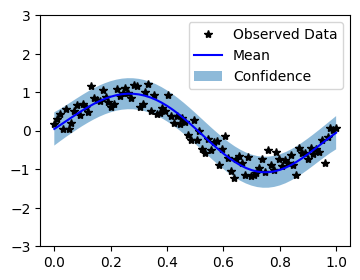

In [36]:
# Plot the Model Fit
with torch.no_grad():
    # Define Plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Obtain Upper and Lower Confidence Bounds
    lcb, ucb = observed_pred.confidence_region()

    # Plot training data (black stars)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

    # Plot predictive means (blue line)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

    # Shade between LCB, UCB
    ax.fill_between(test_x.numpy(), lcb.numpy(), ucb.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Multi-Kernel Composition
In this section, we will discuss how we can compose multiple kernels in an
additive or multiplicative manner in GPyTorch. These examples are adapted from
the [Kernels with Additive or Product Structure](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/kernels_with_additive_or_product_structure.html) notebook provided within the
GPyTorch documentation.

Out of all of the powerful properties that kernels possess, one of the most
powerful is the fact that they possess closure under various composition
operations such as summation and multiplication. Therefore, many covariance
functions can be written as the sum or the product of $m$ component kernels:

$$k_{\text{sum}}(\mathbf{x}, \mathbf{x}') = 
  \sum_{i=1}^{m}k_i(\mathbf{x},\mathbf{x}')$$

$$k_{\text{prod}}(\mathbf{x}, \mathbf{x}') =
  \prod_{i=1}^{m}k_i(\mathbf{x}, \mathbf{x}')$$

There are several reasons for why additive and product kernels are useful.
1. They are typically more interpretable, see [Duvenaud et al. (2011)](https://arxiv.org/pdf/1112.4394).
2. They can be very powerful and expressive, see
   [Wilson and Adams (2013)](https://proceedings.mlr.press/v28/wilson13.pdf).
3. They can be rather sample efficient for Bayesian optimization, see
   [Kandasamy et al. (2015)](https://arxiv.org/pdf/1503.01673) and
   [Gardner et al. (2017)](https://proceedings.mlr.press/v54/gardner17a/gardner17a.pdf).

While the simplest mechanism to perform additive and product compositions of
kernels in GPyTorch is to either add/multiply the kernel objects together or
add/multiply their outputs, there are far more efficient (albeit more complex)
methods to accomplish this. These more efficient methods will also enable us to
utilize significant parallelism, especially when using GPUs for acceleration.

#### Simple Sums and Products
To demonstrate simple sums and products of kernels in GPyTorch, we will consider
the [spectral mixture kernel](https://docs.gpytorch.ai/en/stable/kernels.html#spectralmixturekernel)
that has two components on a univariate input. Without the scaling components,
this kernel can be implemented as:

$$k_{\text{SM}}(x, x') = k_{\text{RBF}}(x, x', \ell_1)k_{\cos}(x, x'; \omega_1)+
  k_{\text{RBF}}(x, x', \ell_2)k_{\cos}(x, x'; \omega_2)$$

where $\ell_1$, $\ell_2$, $\omega_1$, $\omega_2$ are hyperparameters. The code
cell below implements this kernel (naively) in two ways.

In [37]:
# Initialize "toy" data
X = torch.randn(10, 1)

# Define base kernels
rbf_kernel_1 = gpytorch.kernels.RBFKernel()
cos_kernel_1 = gpytorch.kernels.CosineKernel()
rbf_kernel_2 = gpytorch.kernels.RBFKernel()
cos_kernel_2 = gpytorch.kernels.CosineKernel()

# First (Naive) Implementation
spectral_mixture = (rbf_kernel_1 * cos_kernel_1) + (rbf_kernel_2 * cos_kernel_2)
covar = spectral_mixture(X)

# Second (Naive) Implementation
covar = rbf_kernel_1(X) * cos_kernel_1(X) + rbf_kernel_2(X) * cos_kernel_2(X)

In the first implementation, the spectral mixture kernel is created by adding
and multiplying the component kernel objects. On the other hand, in the second
implementation, the kernel is created by adding and multiplying the outputs of
the component kernel objects. Keep in mind that _neither_ implementation should
be used in practice to create the spectral mixture kernel. GPyTorch provides a
far more efficient implementation via the `SpectralMixtureKernel` class.

#### Efficient Parallelism for Kernels with Additive/Product Structure
In the prior section, we discussed the sum and products of kernels with
different forms. However, we are often considering kernels with similar form.
Thus, while the previous example is simple to read, it is rather slow in
practice (under the hood, each kernel and any compositions are computed
sequentially). Specifically, GPyTorch will compute the components in the
following order, one-at-a-time: first cosine kernel, first RBF kernel, the
product of the first cosine and RBF kernels, and so on.

When each of the kernel components have the same functional form then we can
exploit parallelism to obtain massive gains with respect to efficiency. To do
this, we combine all of the component kernels into a **batch kernel** which
allows the component kernels to be computed simultaneously (as opposed to
sequentially, as in the previous example). Then, we compute the sum or product
over the batch dimension with this strategy yielding significant speedups
especially when using a GPU.

**Example 1: Summations of Univariate Kernels**

Let's now consider an example where we assume that we have $d$-dimensional input
data $\boldsymbol{x}, \boldsymbol{x}' \in \mathbb{R}^d$. From this, we will
define an _additive kernel_ that is the sum of $d$ univariate RBF kernels such
that each kernel will operate on a single dimension of the input data.

$$k_{\text{additive}}(\boldsymbol{x}, \boldsymbol{x}') = \prod_{i=1}^{d}
  k_{\text{RBF}}(x^{(i)}, x'^{(i)}; \ell^{(i)})$$

where $\ell^{(i)}$ is the _lengthscale_ associated with dimension $i$. Keep in
mind that we are using a different lengthscale for each of the component
kernels. However, we can still compute each of components in parallel using
batching to increase efficiency. First, we will define a `RBFKernel` object that
is designed to compute a batch of $d$ univariate kernels, as shown below.

In [38]:
# Define RBFKernel object
d = 3

batch_univariate_rbf = gpytorch.kernels.RBFKernel(
    batch_shape=torch.Size([d]),
    ard_num_dims=1,
)

The inclusion of the `batch_shape` argument will ensure that the `lengthscale`
parameter of `batch_univariate_rbf` is a `d x 1 x 1` tensor (such that each
univariate kernel will possess its own lengthscale). If this is omitted then
each univariate kernel would share the same lengthscale.

In order to compute the univariate kernel matrices, we will need to input the
proper dimensions of $\mathbf{X}$ into each kernel. To do this, we reshape the
`n x d` matrix representing $\mathbf{X}$ into a batch of $d$ `n x 1` matrices.

In [39]:
# Reshape X
n = 10
X = torch.randn(n, d)
batched_dims_of_X = X.mT.unsqueeze(-1)

In [40]:
# Feed Batches of Data Into Batched Kernel Object
univariate_rbf_covars = batch_univariate_rbf(batched_dims_of_X)
univariate_rbf_covars.shape

torch.Size([3, 10, 10])

In [41]:
# Obtain Multivariate Kernel by Computing Sum Over Batch
additive_covar = univariate_rbf_covars.sum(dim=-3)
additive_covar.shape

torch.Size([10, 10])

While this approach is comparable to the naive approach discussed previously on
smaller datasets, this approach will become much more efficient as the size of
the dataset increases to higher dimensions. Even more so on the GPU. Let's
compare performance of these two approaches on a larger, higher-dimensioned
dataset.

In [42]:
# Compare Approach Efficiency (Sequential/Naive versus Parallel/Batch)

d = 10    # dimension
n = 500   # number of samples

# Define Device
device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

# Create Data
X = torch.randn(n, d, device=device)

# Define Sequential/Naive Kernel
naive_kernel = (
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[0]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[1]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[2]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[3]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[4]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[5]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[6]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[7]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[8]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[9])
).to(device=device)

# Define Parallel/Batch
batch_kernel = gpytorch.kernels.RBFKernel(
    batch_shape=torch.Size([d]), ard_num_dims=1,
).to(device=device)

# Test Approaches
from torch.utils import benchmark

with gpytorch.settings.lazily_evaluate_kernels(False):
    print(benchmark.Timer(
        stmt="naive_kernel(X)",
        globals={"naive_kernel": naive_kernel, "X": X}
    ).timeit(100))

with gpytorch.settings.lazily_evaluate_kernels(False):
    print(benchmark.Timer(
        stmt="batch_kernel(X.mT.unsqueeze(-1)).sum(dim=-3)",
        globals={"batch_kernel": batch_kernel, "X": X}
    ).timeit(100))

naive_kernel(X)
  10.42 ms
  1 measurement, 100 runs , 1 thread
batch_kernel(X.mT.unsqueeze(-1)).sum(dim=-3)
  8.18 ms
  1 measurement, 100 runs , 1 thread


As shown above, there is an improvement in computational efficiency when the
parallel approach is used. Please note that this cell was run on the CPU only
and therefore a larger performance gap is expected on the GPU. In the next cell,
we put all of this work together to define an efficient additive kernel.

In [43]:
# Define Efficient Additive Kernel
class AdditiveKernelGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, d):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                batch_shape=torch.Size([d]), ard_num_dims=1
            )
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dims_of_X = X.mT.unsqueeze(-1)
        covar = self.covar_module(batched_dims_of_X).sum(dim=-3)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

**Example 2: Products of Univariate Kernels**

In a different example, we consider a multivariate kernel that is defined as the
product of univariate kernels:

$$k_{\text{RBF}}(\boldsymbol{x}, \boldsymbol{x}'; \boldsymbol{\ell}) =
  \prod_{i=1}^{d}k_{\text{RBF}}(x^{(i)}, x'^{(i)}; \ell^{(i)})$$

In [45]:
d = 3
n = 10

batch_rbf_kernel = gpytorch.kernels.RBFKernel(
    batch_shape=torch.Size([d]), ard_num_dims=1,
)
X = torch.randn(n, d)

rbf_covars = batch_rbf_kernel(X.mT.unsqueeze(-1))
with gpytorch.settings.lazily_evaluate_kernels(False):
    prod_covar = rbf_covars.prod(dim=-3)
prod_covar.shape

torch.Size([10, 10])

Note that this example in particular is silly since the multivariate RBF kernel
is exactly equivalent to the product of $d$ univariate RBF kernels:

$$k_{\text{RBF}}(\boldsymbol{x}, \boldsymbol{x}') = \prod_{i=1}^{d}
  k_{\text{RBF}}(x^{(i)}, x'^{(i)})$$

However, this strategy becomes advantageous when each of the univariate kernel
components are approximated using a scalable $<<\mathcal{O}(n^3)$ approximation
for each of the univariate kernels.

### Defining a Custom Kernel
In this section, we will examine how to implement a custom kernel in GPyTorch.
These examples are adapted from the
[Implementing a Custom Kernel](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Implementing_a_custom_Kernel.html)
notebook provided within the GPyTorch documentation.

Before we begin, we will define some training data and helper functions.

In [74]:
# Define Training Data
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

"""
Training data is 100 points, evenly spaced in the range [0, 1]
"""
train_x = torch.linspace(0, 1, 100)

"""
True function is sin(2 * pi * x) with Gaussian noise
"""
train_y = (torch.sin(train_x * (2 * math.pi)) +
           torch.randn(train_x.size()) * math.sqrt(0.04))

In [75]:
# Define Helper Functions for Training, Predicting, and Plotting
def train(model, likelihood, training_iter=training_iter):
    # Use Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # Define the "Loss" for GPs - the marginal log-likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Obtain output from model
        output = model(train_x)

        # Compute loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


def predict(model, likelihood, test_x=torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        return likelihood(model(test_x))


def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Define plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Obtain Upper and Lower Confidence Bounds
        lcb, ucb = observed_pred.confidence_region()

        # Plot Training Data (black stars)
        ax.plot(train_x.numpy(), train_y.numpy(), "k*")

        # Plot Predictive Means (blue line)
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), "b")

        # Shade Confidence Region
        ax.fill_between(test_x.numpy(), lcb.numpy(), ucb.numpy(), alpha=0.5)

        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

To implement our own custom kernel, we can derive one from the GPyTorch `Kernel`
class and implement the `forward()` method. The base class provides us with many
useful routines. For instance, `__call__()` is implemented meaning that the
kernel can be called directly, without needing to resort to the `forward()`
routine. In addition, the `Kernel` class also provides a method `covar_dist()`
that can be used to compute the Euclidean distance between point pairs.

In [76]:
# Define Custom Kernel
class FirstSincKernel(gpytorch.kernels.Kernel):
    # The sinc kernel is stationary
    is_stationary = True

    def forward(self, x1, x2, **params):
        """
        This is the kernel function. It should return a `torch.Tensor` or a
        `linear_operator.operators.LinearOperator`, when called on two tensors.
        """
        # Calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)

        # Prevent Divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))

        # Return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

Now that this kernel is ready to use, we can define a GP-model, similar to
examples previously discussed in this notebook.

In [77]:
# Define GP Model
class FirstGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = FirstSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Using this GP model, which uses our custom kernel, we can train and evaluate
the model.

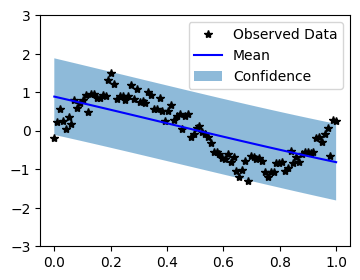

In [78]:
# Initialize Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = FirstGPModel(train_x, train_y, likelihood)

# Put Model in Training Mode
model.train()
likelihood.train()

# Train Model
train(model, likelihood)

# Put Model in Evaluation Mode
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)

# Plot Results
plot(observed_pred)

As we can see, the kernel does not perform well due to the fact that it lacks a
lengthscale parameter. We will add this next.

**Adding Hyperparameters**

As seen previously, while we were able to use the kernel to define a GP model,
its performance is less than sufficient since it lacks a lengthscale parameter.
A _lengthscale parameter_ controls the correlation length and in GPyTorch, the
lengthscale is implemented as a hyperparameter.

First, the parameter must be registered using the method `register_parameter()`.
The `Kernel` class inherits this method from `Module`. We will register the
constraints and priors in a similar manner.

In [79]:
# Import Positivity Constraint
from gpytorch.constraints import Positive

In [80]:
# Re-Define Kernel
class SincKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    # Register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # Register the raw parameter
        self.register_parameter(
            name='raw_length',
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # Set the parameter constraint to be positive, if nothing is specified
        if length_constraint is None:
            length_constraint = Positive()

        # Register the constraint
        self.register_constraint("raw_length", length_constraint)

        # Set the parameter prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m.set_length(v),
            )
    
    # Now set up the 'actual' parameter
    @property
    def length(self):
        # When accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)
    
    @length.setter
    def length(self, value):
        return self._set_length(value)
    
    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
    
    def forward(self, x1, x2, **params):
        """
        This is the kernel function.
        """
        # Apply lengthscale
        x1_ = x1.div(self.length)
        x2_ = x2.div(self.length)

        # Compute distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)

        # Prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))

        # Return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

Now, we can use this re-defined version of the `SincKernel` to define a new
GP model, train it and make predictions.

In [81]:
# Define new GP model
class SincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

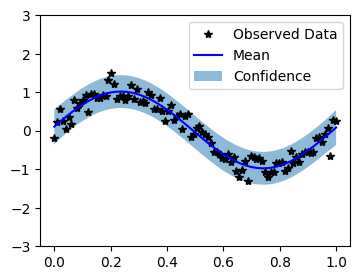

In [82]:
# Initialize New Model
model = SincGPModel(train_x, train_y, likelihood)

# Set Model to Training Mode
model.train()
likelihood.train()
train(model, likelihood)

# Set Model to Evaluation Mode
model.eval()
likelihood.eval()

# Make Predictions
observed_pred = predict(model, likelihood)

# Plot Results
plot(observed_pred)

Clearly, adding the lengthscale helped the kernel perform much better when
modeling the observed data. However, since many kernels use a lengthscale, there
is a much simpler way to implement it in custom kernels. This is accomplished by
using the `has_lengthscale` attribute from the `Kernel` class.

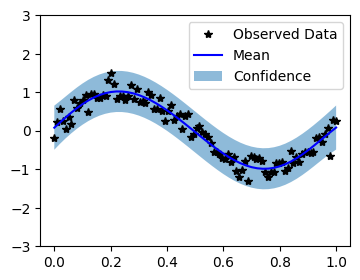

In [83]:
# Simpler Implementation of Lengthscale
class SimpleSincKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True

    def forward(self, x1, x2, **params):
        """
        This is the kernel function.
        """
        # Apply lengthscale
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)

        # Compute distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)

        # Prevent Divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))

        # Return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

class SimpleSincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SimpleSincKernel()
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = SimpleSincGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()
train(model, likelihood)

model.eval()
likelihood.eval()

observed_pred = predict(model, likelihood)
plot(observed_pred)

### Assessing GP Model Generalization (Metrics)
In this section, we review the various metrics provided by GPyTorch that can be
used to assess the generalization of Gaussian process models. These examples are
adapted from the
[Tutorial on Metrics](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Metrics.html)
notebook provided within the GPyTorch documentation.

To evaluate GPyTorch models, we will use probabilistic metrics. We will modeling
the function

$$y = \sin(2\pi x) + \epsilon$$

$$\epsilon \sim \mathcal{N}(0, 0.04)$$

In [84]:
# Define Training Data
train_x = torch.linspace(0, 1, 100)
train_y = (torch.sin(train_x * (2 * math.pi)) +
           torch.randn(train_x.size()) * math.sqrt(0.04))

# Define Testing Data
test_x = torch.linspace(0, 1, 51)
test_y = (torch.sin(test_x * (2 * math.pi)) +
          torch.randn(test_x.size()) * math.sqrt(0.04))

In [85]:
# Define Simple GP Regression Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [86]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

The model is ready for hyperparameter learning but let's first check how it
performs on the test data.

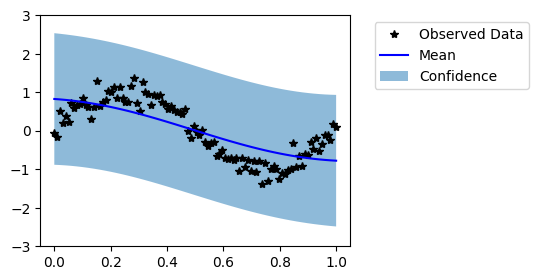

In [87]:
# Check Model Performance Before Learning
model.eval()
with torch.no_grad():
    untrained_pred_dist = likelihood(model(test_x))
    predictive_mean = untrained_pred_dist.mean
    lcb, ucb = untrained_pred_dist.confidence_region()

f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x, train_y, 'k*')
ax.plot(test_x, predictive_mean, 'b')
ax.fill_between(test_x, lcb, ucb, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6, 1))
plt.show()

Visually, this does not look like a good fit. Thus, we will now train the model
hyperparameters.

In [88]:
# Train the Model
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    
    if (i + 1) % 10 == 0:
        print('Iteration %d/%d - Loss: %.3f    lengthscale: %.3f    noise: %.3f'
               % (i + 1, training_iter, loss.item(),
                  model.covar_module.base_kernel.lengthscale.item(),
                  model.likelihood.noise.item()
                 )
        )

    optimizer.step()

Iteration 10/50 - Loss: 0.545    lengthscale: 0.342    noise: 0.339
Iteration 20/50 - Loss: 0.191    lengthscale: 0.211    noise: 0.134
Iteration 30/50 - Loss: -0.064    lengthscale: 0.257    noise: 0.053
Iteration 40/50 - Loss: -0.079    lengthscale: 0.316    noise: 0.029
Iteration 50/50 - Loss: -0.085    lengthscale: 0.277    noise: 0.030


Next, let's reevaluate the model on the test data.

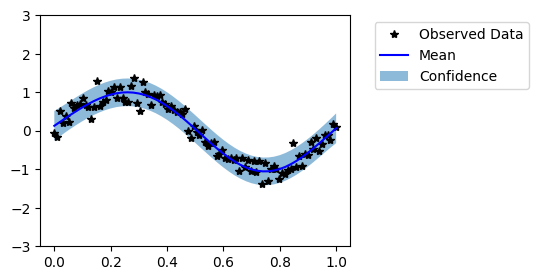

In [89]:
model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(test_x))
    pred_mean = trained_pred_dist.mean
    lcb, ucb = trained_pred_dist.confidence_region()

f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x, train_y, 'k*')
ax.plot(test_x, pred_mean, 'b')
ax.fill_between(test_x, lcb, ucb, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6, 1))
plt.show()

After training, the fit is visually much better. However, in order to get a
quantitative measurement for how "good" the fit is, we can use various
probabilistic metrics. In particular, when applying models to high-dimensional
data it can be difficult (and more often than not, impossible) to visualize the
model's performance. Recall that we have saved the predictive distributions from
untrained and trained models as `untrained_pred_dist` and `trained_pred_dist`,
respectively.

**Negative Log Predictive Density (NLPD)**

Negative Log Predictive Density (NLPD) is one of the most standard probabilistic
metric for evaluating GP models. Simply put, NLPD is the negative log-likelihood
of the test data given the predictive distribution.

In [90]:
# Negative Log Predictive Density (NLPD)
from gpytorch.metrics import negative_log_predictive_density as nlpd

init_nlpd = nlpd(untrained_pred_dist, test_y)
final_nlpd = nlpd(trained_pred_dist, test_y)

print(f'Untrained model NLPD: {init_nlpd:.2f}, \nTrained model NLPD: {final_nlpd:.2f}')

Untrained model NLPD: 0.86, 
Trained model NLPD: -0.20


**Mean Standardized Log Loss (MSLL)**

Mean Standardized Log Loss (MSLL) computes the average negative log-likelihood
of all test points with respect to their univariate predictive densities. Note
that it is also possible to calculate the quantile coverage error.

In [91]:
# Mean Standardized Log Loss (MSLL)
from gpytorch.metrics import mean_standardized_log_loss as msll

init_msll = msll(untrained_pred_dist, test_y)
final_msll = msll(trained_pred_dist, test_y)

print(f'Untrained model MSLL: {init_msll:.2f}, \nTrained model MSLL: {final_msll:.2f}')

Untrained model MSLL: 0.86, 
Trained model MSLL: -0.19


In [92]:
# Quantile Coverage Error
from gpytorch.metrics import quantile_coverage_error
quantile = 95
qce = quantile_coverage_error(trained_pred_dist, test_y, quantile=quantile)
print(f'Quantile {quantile}% Coverage Error: {qce:.2f}')

Quantile 95% Coverage Error: 0.03


**Mean Squared Error (MSE)**

Mean Squared Error (MSE) computes the mean of the squared difference between the
test observations and the predictive mean. MSE is a standard metric for
evaluating regression models although it cannot take uncertainty into account
unlike NLPD, MLSS, and ACE.

In [93]:
# Mean Squared Error (MSE)
from gpytorch.metrics import mean_squared_error as mse

init_mse = mse(untrained_pred_dist, test_y, squared=True)
final_mse = mse(trained_pred_dist, test_y, squared=True)

print(f'Untrained model MSE: {init_mse:.2f}, \nTrained model MSE: {final_mse:.2f}')

Untrained model MSE: 0.17, 
Trained model MSE: 0.04


**Mean Absolute Error (MAE)**

Mean Absolute Error (MAE) computes the mean of the absolute difference between
the test observations and the predictive mean. This metric is less sensitive to
outliers than MSE.

In [94]:
# Mean Absolute Error (MAE)
from gpytorch.metrics import mean_absolute_error as mae

init_mae = mae(untrained_pred_dist, test_y)
final_mae = mae(trained_pred_dist, test_y)

print(f'Untrained model MAE: {init_mae:.2f}, \nTrained model MAE: {final_mae:.2f}')

Untrained model MAE: 0.35, 
Trained model MAE: 0.16


## GAUCHE Implementation

### Examples

## Implementation Comparison